In [47]:
import numpy as np
from numpy import array 
import seaborn as sns
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt
import pickle
import warnings
import sympy
import numpy
from sympy.interactive import printing
printing.init_printing(use_latex="mathjax")
warnings.filterwarnings("ignore")

In [48]:
# load the dataset
dataframe = pd.read_excel("datasets/tasador2_experimento2.xlsx")
dataframe = dataframe[dataframe['precio'] < 25000]
#dataframe['precio'] = dataframe['precio']/dataframe['area_construida']

In [49]:
dataframe.shape

(744, 14)

In [50]:
dataframe

,id,precio,dormitorios,banos,estacionamientos,operacion,tipo_propiedad,region,comuna,area_total,area_construida,condicion,longitud,latitud
0,29292,6900.00,2,2,1,0,1,5,6,63.0,63.0,1,-71.544289,-32.955273
1,29926,5500.00,3,2,1,0,1,5,6,100.0,100.0,1,-71.553032,-33.026428
2,29824,6900.00,3,2,1,0,1,5,6,100.0,100.0,1,-71.547234,-32.955006
3,29714,2269.83,3,2,0,0,1,5,4,60.0,60.0,1,-71.590477,-33.056507
4,29684,7000.00,2,2,1,0,1,5,6,83.0,83.0,1,-71.544380,-32.959328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,20220898,12000.00,5,5,5,0,0,5,6,765.0,284.0,1,-71.543713,-32.971533
781,20220899,10300.00,3,3,2,0,1,5,6,146.0,129.0,1,-71.545167,-32.948877
782,20220902,10937.50,5,4,3,0,0,5,6,320.0,525.0,1,-71.530181,-33.030358
783,20220905,12000.00,5,5,5,0,1,5,6,765.0,284.0,1,-71.543713,-32.971533


In [51]:
# split data into input and output columns
#X, y = dataframe.drop(['precio','id','operacion','region','tipo_propiedad','condicion'], axis = 1), dataframe['precio']
X_all, y = dataframe.drop(['precio','id','operacion','region'], axis = 1), dataframe['precio']

In [52]:
select = SelectKBest(f_regression, k=10)
z = select.fit_transform(X_all, y)
print("After selecting best k features:", z.shape) 

After selecting best k features: (744, 10)


In [53]:
filter = select.get_support()
features = array(X_all.columns)

In [54]:
#variables seleccionadas
cols = features[filter]
cols

array(['dormitorios', 'banos', 'estacionamientos', 'tipo_propiedad',
       'comuna', 'area_total', 'area_construida', 'condicion', 'longitud',
       'latitud'], dtype=object)

In [55]:
#Asigna a X los datos con las variables independientes seleccionadas
X = X_all[cols.tolist()]

In [56]:
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state = 1)

In [57]:
#Aplica transformación logaritmica a la variable y de entrenamiento para normalizarla
y_train_transformed = np.log(train_y)

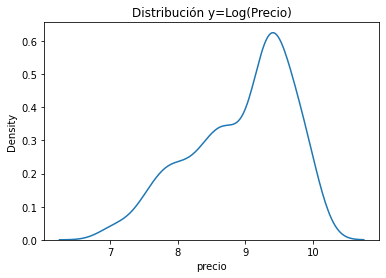

In [58]:
plt.title("Distribución y=Log(Precio)")
ax1=sns.distplot(y_train_transformed, hist=False)
#sns.distplot(ypred, hist=False, ax=ax1)
plt.show()

In [59]:
#Se escalan todos los datos
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#escalar = StandardScaler()
escalar = MinMaxScaler()
train_X = escalar.fit_transform(train_X)
test_X = escalar.transform(test_X)

In [60]:
# Instanciar el algoritmo
xgb_r = xg.XGBRFRegressor(n_estimators = 80, 
                        max_depth = 10, 
                       # learning_rate = 0.001,
                       # reg_lambda = 0.1, 
                        subsample = 0.8, 
                        colsample_bynode=0.5,
                        #colsample_bytree = 0.4, 
                        #colsample_bylevel = 0.4, 
                        #min_child_weight= 0.5,
                        #gamma = 0.25, 
                        tree_method = 'gpu_hist')

#XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.2, tree_method = 'gpu_hist')

In [61]:
xgb_r

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.5, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain',
               interaction_constraints=None, max_delta_step=None, max_depth=10,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=80, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', random_state=None, reg_alpha=None,
               scale_pos_weight=None, tree_method='gpu_hist',
               validate_parameters=None, verbosity=None)

In [62]:
#transforming target variable through quantile transformer
xgb_ttr = TransformedTargetRegressor(regressor=xgb_r, transformer=QuantileTransformer(output_distribution='normal'))

# Fitting the model
xgb_ttr.fit(train_X, y_train_transformed)
xgb_r.fit(train_X, y_train_transformed)
  
# Predict the model
ypred = xgb_ttr.predict(test_X)


#Aplica transformación inversa logaritmica a la variable y de entrenamiento
ypred = np.exp(ypred)

In [63]:
results_dict = {}
R2 = metrics.r2_score(test_y, ypred)
RMSE = np.sqrt(metrics.mean_squared_error(test_y, ypred))
MAE=metrics.mean_absolute_error(test_y, ypred)
MSE = metrics.mean_squared_error(test_y, ypred)

# guarda resultados en dict
results_dict["XGBRFRegressor"] = [R2, RMSE,MAE,MSE]
df_results = pd.DataFrame.from_dict(results_dict, orient="index", columns=["R2", "RMSE","MAE","MSE"])

In [64]:
df_results

,R2,RMSE,MAE,MSE
XGBRFRegressor,0.833446,2263.12816,1525.590409,5.121749e+06


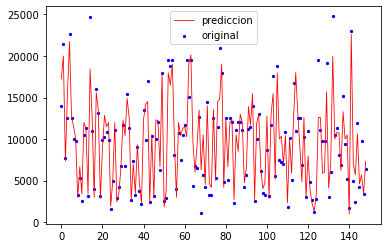

In [65]:
x_ax = range(len(ypred))
plt.scatter(x_ax, test_y, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="prediccion")
plt.legend()
plt.show()

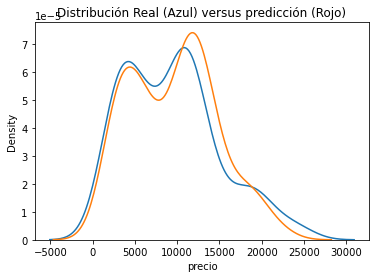

In [66]:
plt.title("Distribución Real (Azul) versus predicción (Rojo)")
ax1=sns.distplot(test_y, hist=False)
sns.distplot(ypred, hist=False, ax=ax1)
plt.show()

<AxesSubplot:xlabel='precio'>

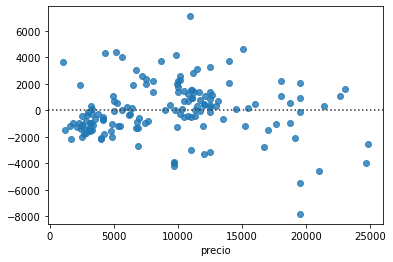

In [67]:
sns.residplot(test_y,ypred)

Los diagramas de Distribución y Residuales confirman que existe una buena superposición entre los cargos previstos y los reales. Sin embargo, hay un puñado de valores pronosticados que están mucho más allá del eje x y esto hace que nuestro RMSE sea más alto. Esto se puede reducir aumentando nuestros puntos de datos, es decir, recopilando más datos!!!.

# Análisis de heterocedasticidad

In [68]:
#valores observados
y = test_y
#valores predichos
p = ypred
residuals = y - p

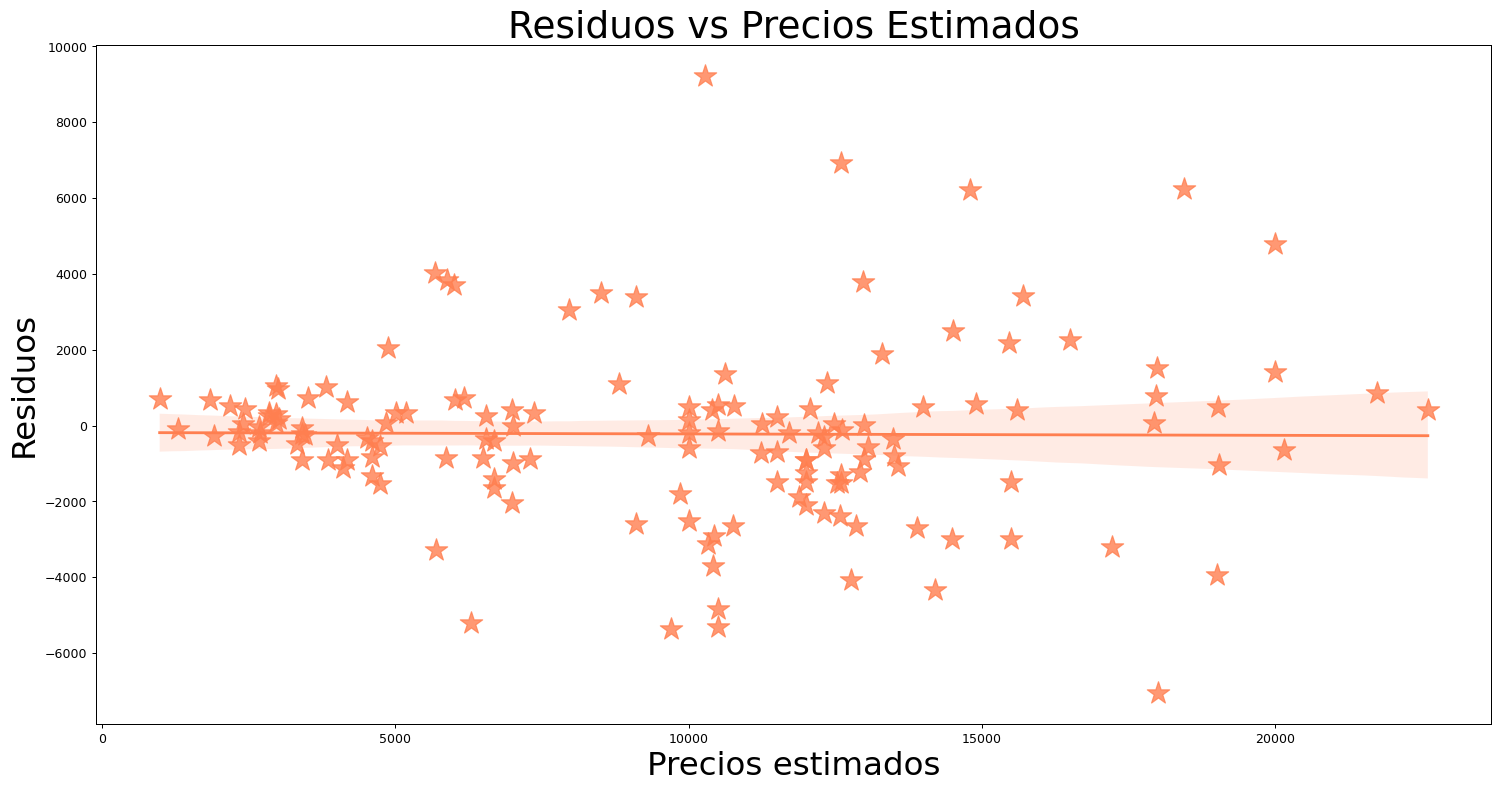

In [69]:
plt.figure(num=3, figsize=(20, 10), dpi=90, facecolor='w',edgecolor='green')
sns.regplot(p, residuals, data=dataframe, marker='*', scatter_kws={'s': 350}, color='coral')
plt.title('Residuos vs Precios Estimados', size=30)
SIZE2=20
plt.rc('xtick', labelsize=SIZE2) # fontsize of the tick X labels
plt.rc('ytick', labelsize=SIZE2) # fontsize of the tick Y labels

plt.xlabel('Precios estimados', size=26)
plt.ylabel('Residuos', size=26)
plt.show()

<p data-adtags-visited="true">En general, si hay&nbsp; patrones evidentes en los residuos, el modelo tiene un problema y es muy posible que no se pueda confiar en los resultados de significación de los coeficientes. Típicamente, un patrón claramente revelador para la heterocedasticidad es <strong>que a medida que aumenten los valores predichos por el modelo, también aumente la varianza de sus residuos.</strong></p>
<span style="color:#000000;">No tenemos un patrón claramente identificable, a parte de algunos valores atípicos.</span>

<strong>TEST DE BREUSCH-PAGAN</strong>

<p data-adtags-visited="true">En estadística, el <b>test de Breusch-Pagan</b> para determinar la heterocedasticidad en un modelo de regresión lineal. Analiza si la varianza estimada de los residuos del modelo dependen de los valores de los regresores a partir de construir un modelo con los errores al cuadrado como variable dependiente, manteniendo los mismos regresores.</p>

<ul>
<li><strong>Hipotesis 0: Tenemos residuos homostedásticos.</strong></li>
<li><strong>Hipotesis 1: Tenemos residuos heterocedasticos</strong></li>
</ul>

In [70]:
import statsmodels.stats.api as sms
name = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
test = sms.het_breuschpagan(residuals, test_X)
x = zip(name, test)
print(list(x))

[('Lagrange multiplier statistic', 38.925912131114366), ('p-value', 1.1880370205284698e-05), ('f-value', 4.915509082091904), ('f p-value', 4.467299489786909e-06)]


<p data-adtags-visited="true">Observamos que el valor del F-stadistico 2.011 tiene un valor P Prob (F-statistic): <p>El valor p es <strong>0.0368</strong> . Si usamos un nivel de significancia de α = 0.05, rechazaríamos la hipótesis nula de nuestra prueba de hipótesis porque este valor p es menor que 0.05.</p> o sea los residuos del modelo no son homostedásticos,<strong> y determinamos que nuestro modelo  presenta heteroscedestacidad</strong>.</p>

# Importancia de las variables

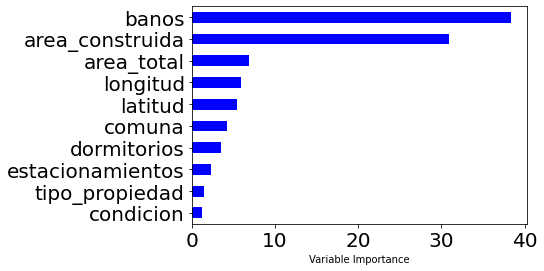

In [71]:
Importance = pd.DataFrame({'Importance':xgb_r.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'b', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [26]:
# Grabar el modelo a disco
archivo_sav= 'tasador_xgboost_experimento2.sav'
pickle.dump(xgb_ttr, open(archivo_sav, 'wb'))